# Online IC Regression Analysis

## Table of Contents

- **Section 0. Setup**
  - 0.1 Import packages and define paths
  - 0.2 Project directories

- **Section 1. Exploratory Analysis**
  - 1.1 Load processed export data
  - 1.2 Plot export trends (linear + log, with values & trend lines)
  - 1.3 Compute CAGR summary

- **Section 2. Feature Engineering**
  - 2.1 Import policy event dummies (placeholder / dataset)
  - 2.2 Import global demand proxy (placeholder / dataset)
  - 2.3 Merge exports, events, and demand data
  - 2.4 Construct market share and interaction terms

- **Section 3. Regression Modeling**
  - 3.1 Baseline OLS regression
  - 3.2 HAC robust errors (time series adjustment)
  - 3.3 Residual diagnostics

- **Section 4. Model Extensions**
  - 4.1 Log-transform vs. level regression
  - 4.2 Country fixed effects
  - 4.3 Interaction effects

- **Section 5. Outputs**
  - 5.1 Save regression summaries
  - 5.2 Save regression dataset


# Section 1: Exploratory Analysis

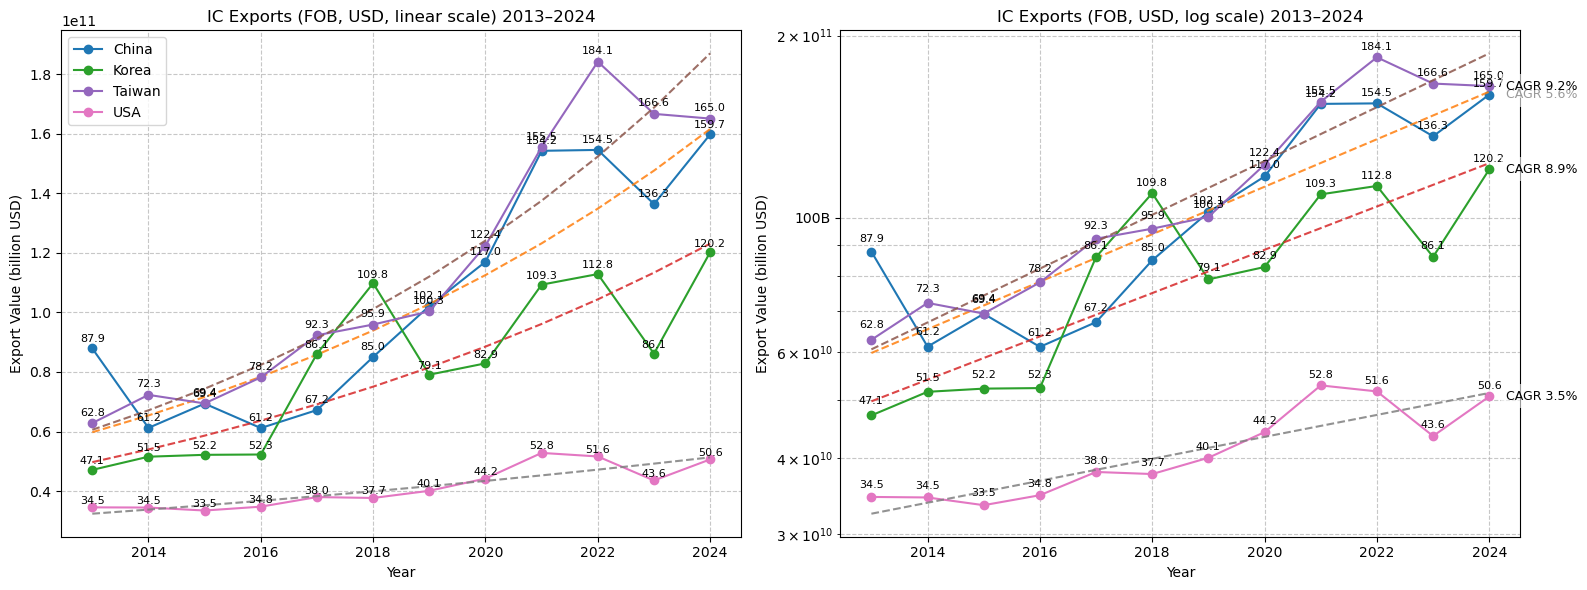

Âπ¥‰ªΩË¶ÜËìãÊ™¢Êü•Ôºö
          min   max  count
Country                   
China    2013  2024     12
Korea    2013  2024     12
Taiwan   2013  2024     12
USA      2013  2024     12


Country  StartYear  EndYear  Years  StartValue(BillionUSD)  \
2  Taiwan     2013.0   2024.0   11.0                   62.82   
1   Korea     2013.0   2024.0   11.0                   47.12   
0   China     2013.0   2024.0   11.0                   87.88   
3     USA     2013.0   2024.0   11.0                   34.54   

   EndValue(BillionUSD)  CAGR(%)  TotalGrowth(%)  
2                165.04     9.18          162.71  
1                120.19     8.89          155.08  
0                159.75     5.58           81.78  
3                 50.63     3.54           46.58

‚úÖ Saved: /home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/outputs/regression/cagr_summary_2013_2024.csv


In [1]:
# === 1.1 ÂåØÂÖ•Ë≥áÊñô ===
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mticker
from pathlib import Path

PROC_DIR = Path("/home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/processed")
df = pd.read_csv(PROC_DIR / "ic_exports_comparison.csv")

# Ê®ôÊ∫ñÂåñÂúãÂÆ∂ÂêçÁ®±
df["Country"] = df["Country"].replace({
    "Rep. of Korea": "Korea",
    "USA": "USA",
    "China": "China",
    "Taiwan": "Taiwan"
})

# Âü∫Á§éÊï¥ÁêÜÔºöÊéíÂ∫è„ÄÅÂûãÂà•
df = df.sort_values(["Country","Year"]).reset_index(drop=True)
df["Year"] = df["Year"].astype(int)
df.head()

# === 1.2 Âá∫Âè£ÈáëÈ°çË∂®Âã¢Âúñ (linear + log, Âê´Êï∏Â≠ó„ÄÅË∂®Âã¢Á∑ö„ÄÅCAGR) ===
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharex=True)
countries = df["Country"].unique()

for ax, scale in zip(axes, ["linear", "log"]):
    for country in countries:
        sub = df[df["Country"] == country].sort_values("Year")
        X = sub["Year"].values.reshape(-1,1)
        y = sub["ExportValue(USD)"].values

        # ÊäòÁ∑ö
        ax.plot(sub["Year"], y, marker="o", label=country)

        # Èªû‰∏äÊï∏Â≠óÔºàÂçÅÂÑÑUSDÔºåÂæÆÂ∞è‰ΩçÁßªÈÅøÂÖçÈáçÁñäÔºâ
        for x, val in zip(sub["Year"], y):
            ax.text(x, val*(1.01 if scale=="log" else 1.0)+0.01*y.max(),
                    f"{val/1e9:.1f}", ha="center", va="bottom", fontsize=8)

        # ÊåáÊï∏Ë∂®Âã¢Á∑ö
        model = LinearRegression().fit(X, np.log(y))
        y_pred = np.exp(model.predict(X))
        ax.plot(sub["Year"], y_pred, linestyle="--", alpha=0.85)

        # CAGR (Âè™Âú® log ÂúñÈ°ØÁ§∫)
        if scale == "log":
            y0, yT = y[0], y[-1]
            n_years = sub["Year"].iloc[-1] - sub["Year"].iloc[0]
            cagr = (yT / y0) ** (1/n_years) - 1
            ax.text(sub["Year"].iloc[-1] + 0.3, y[-1],
                    f"CAGR {cagr*100:.1f}%", fontsize=9,
                    va="center", ha="left",
                    bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    ax.set_title(f"IC Exports (FOB, USD, {scale} scale) 2013‚Äì2024")
    ax.set_xlabel("Year")
    ax.set_ylabel("Export Value (billion USD)")
    ax.set_yscale(scale)
    if scale == "log":
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, _: f"{v/1e9:.0f}B"))
    ax.grid(True, which="both", linestyle="--", alpha=0.7)

axes[0].legend(loc="upper left")
plt.tight_layout()
plt.show()

# === 1.3 Ë®àÁÆó‰∏¶Ëº∏Âá∫ CAGR Ë°®Ê†ºÔºàÂõõÂúãÁâàÔºåÂêçÁ®±Â∑≤Ê®ôÊ∫ñÂåñÔºâ ===
def compute_cagr(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values("Year")
    y0, yT = g["ExportValue(USD)"].iloc[0], g["ExportValue(USD)"].iloc[-1]
    t0, tT = int(g["Year"].iloc[0]), int(g["Year"].iloc[-1])
    n_years = max(1, tT - t0)
    cagr = (yT / y0) ** (1 / n_years) - 1
    total_growth = yT / y0 - 1
    return pd.Series({
        "StartYear": t0, "EndYear": tT, "Years": n_years,
        "StartValue(BillionUSD)": y0/1e9, "EndValue(BillionUSD)": yT/1e9,
        "CAGR(%)": cagr*100, "TotalGrowth(%)": total_growth*100
    })

print("Âπ¥‰ªΩË¶ÜËìãÊ™¢Êü•Ôºö")
print(df.groupby("Country")["Year"].agg(["min","max","count"]))

cagr_tbl = (df.groupby("Country")
              .apply(compute_cagr)
              .reset_index()
              .sort_values("CAGR(%)", ascending=False))

display(cagr_tbl.round(2))

# Â≠òÊ™î
OUT_DIR = PROC_DIR.parent / "outputs" / "regression"
OUT_DIR.mkdir(parents=True, exist_ok=True)
cagr_tbl.to_csv(OUT_DIR / "cagr_summary_2013_2024.csv", index=False)
print("‚úÖ Saved:", OUT_DIR / "cagr_summary_2013_2024.csv")


### Section 1 Summary: Exploratory Analysis

Âú®ÈÄôÂÄãÈÉ®ÂàÜÔºåÊàëÂÄëÂÆåÊàê‰∫ÜÂõõÂúã (China„ÄÅKorea„ÄÅTaiwan„ÄÅUSA) 2013‚Äì2024 Âπ¥ IC Âá∫Âè£Ë≥áÊñôÁöÑÊé¢Á¥¢ÊÄßÂàÜÊûê„ÄÇ

**1. Ë≥áÊñôÊï¥ÁêÜ**
- Â∑≤Â∞áÂõõÂúãË≥áÊñôÊï¥ÂêàÁÇ∫‰∏ÄËá¥Ê†ºÂºèÔºåÂπ¥‰ªΩÂ∞çÈΩä 2013‚Äì2024„ÄÇ
- ÊØèÂúãÁöÜÊúâÂÆåÊï¥ 12 Á≠ÜÂπ¥Â∫¶Ë≥áÊñô„ÄÇ

**2. Âá∫Âè£Ë∂®Âã¢Âúñ**
- **Linear scale**ÔºöÂ±ïÁ§∫ÁµïÂ∞çÂá∫Âè£Ë¶èÊ®°„ÄÇ‰∏≠ÂúãÈï∑Êúü‰øùÊåÅÊúÄÂ§ßÂá∫Âè£È°çÔºåÂè∞ÁÅ£Âú® 2021‚Äì2022 Âá∫ÁèæÈ´òÂ≥∞ÔºåÈüìÂúãÁ©©ÂÆöÊàêÈï∑ÔºåÁæéÂúãË¶èÊ®°ÊúÄÂ∞è„ÄÇ
- **Log scale**ÔºöÊõ¥ÂÆπÊòìÊØîËºÉÂ¢ûÈï∑ÈÄüÂ∫¶„ÄÇÂä†‰∏ä‰∫ÜÊåáÊï∏Ë∂®Âã¢Á∑öÂíå CAGR Ê®ôË®ª„ÄÇ

**3. CAGR ÂàÜÊûê**
- **Taiwan**ÔºöCAGR ~ **9.2%**ÔºåÊàêÈï∑ÂπÖÂ∫¶ÊúÄÂ§ß (Âæû ~628 ÂÑÑÂà∞ ~1650 ÂÑÑ USD)„ÄÇ
- **Korea**ÔºöCAGR ~ **8.9%**ÔºåÂá∫Âè£È°çÂæû 471 ÂÑÑÂà∞ 1200 ÂÑÑ„ÄÇ
- **China**ÔºöCAGR ~ **5.6%**ÔºåË¶èÊ®°ÊúÄÂ§ß‰ΩÜÂ¢ûÈÄü‰ΩéÊñºÂè∞Èüì„ÄÇ
- **USA**ÔºöCAGR ~ **3.5%**ÔºåË¶èÊ®°ËàáÂ¢ûÈÄüÁõ∏Â∞çÊúÄÂ∞è„ÄÇ

**ÁµêË´ñ**
- Âè∞ÁÅ£ËàáÈüìÂúãÊòØÁõ∏Â∞çÈ´òÊàêÈï∑Â∏ÇÂ†¥Ôºå‰∏≠ÂúãÈõñÁÑ∂Ë¶èÊ®°ÊúÄÂ§ß‰ΩÜÂ¢ûÈÄüËºÉ‰ΩéÔºåÁæéÂúãÂâáÁ∂≠ÊåÅ‰ΩéÈÄüÊàêÈï∑„ÄÇ
- ÈÄô‰∫õËßÄÂØüÂ∞á‰ΩúÁÇ∫ **Section 2 Regression Analysis** ÁöÑÂü∫Á§éÔºåÂæåÁ∫åÂèØÊ™¢È©óÊîøÁ≠ñ‰∫ã‰ª∂„ÄÅÈúÄÊ±ÇÂõ†Â≠êÊòØÂê¶ËÉΩËß£ÈáãË∂®Âã¢„ÄÇ


## Section 2: Regression Analysis

ÁõÆÊ®ôÔºöÊ™¢È©ó‰∫ã‰ª∂Ôºàpolicy dummiesÔºâËàáÂÖ®ÁêÉÈúÄÊ±ÇÔºàproxyÔºâÂ∞çÂêÑÂúã IC Âá∫Âè£ÁöÑÂΩ±Èüø„ÄÇ
- ‰ª• **log(Âá∫Âè£ÂÄº)** ÁÇ∫‰æùËÆäÊï∏ ‚Üí ‰øÇÊï∏ÂèØËß£ËÆÄÁÇ∫ÁôæÂàÜÊØîÂΩ±Èüø„ÄÇ
- Á¥çÂÖ• **ÂúãÂÆ∂Âõ∫ÂÆöÊïàÊûú**Ôºàcountry dummiesÔºâ„ÄÇ
- ÂêåÊôÇÁ§∫ÁØÑ **HAC(Newey‚ÄìWest)** Ëàá **HC1** Á©©ÂÅ•Ê®ôÊ∫ñË™§„ÄÇ
- Á§∫ÁØÑ **‰∫ã‰ª∂√óÂè∞ÁÅ£** ‰∫§‰∫íÈ†ÖÔºåÊ™¢Êü•Âè∞ÁÅ£ÊòØÂê¶Êõ¥ÊïèÊÑü„ÄÇ


In [2]:
# ========================
# Section 2: Regression Analysis (TWFE ÁâàÊú¨)
# Â∞àÊ≥®Ê™¢È©ó‰∫ã‰ª∂Â∞çÂè∞ÁÅ£ÁöÑÈ°çÂ§ñÊïàÊûú
# ========================

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from pathlib import Path

# Áî® Section 1 ÁöÑ dfÔºà‰øùÁïô Country Ê¨Ñ‰ΩçÔºâ
df_twfe = df.copy().sort_values(["Country", "Year"]).reset_index(drop=True)
df_twfe["log_exports"] = np.log(df_twfe["ExportValue(USD)"])
df_twfe["is_Taiwan"]   = (df_twfe["Country"] == "Taiwan").astype(int)

# === ‰∫ã‰ª∂Ê∏ÖÂñÆÔºà2013‚Äì2024Ôºâ===
# Âª∫Ë≠∞Á≤æÁ∞°ÔºåÈÅøÂÖçÈ´òÂ∫¶ÂÖ±Á∑öÔºõÈÄôË£°‰øùÁïôÂπæÂÄã‰∏ªË¶Å‰∫ã‰ª∂
EVENTS = {
    "TradeWar2018": 2018,  # Áæé‰∏≠Ë≤øÊòìÊà∞
    "Covid2020"   : 2020,  # Êñ∞ÂÜ†Áñ´ÊÉÖ
    "ChipShort2021":2021,  # ÂÖ®ÁêÉÊô∂ÁâáËçí
    "ChipAct2022" : 2022,  # ÁæéÂúãCHIPSÊ≥ïÊ°à
    "USBan2023"   : 2023,  # AI GPU Â∞ç‰∏≠Âá∫Âè£ÁÆ°Âà∂
}

# Âª∫Á´ã‰∫ã‰ª∂ dummy Ëàá Âè∞ÁÅ£‰∫§‰∫íÈ†Ö
for ev, yr in EVENTS.items():
    df_twfe[ev] = (df_twfe["Year"] >= yr).astype(int)
    df_twfe[f"TW_{ev}"] = df_twfe[ev] * df_twfe["is_Taiwan"]

# 2.1 TWFE Ê®°ÂûãÔºàYear FE + Country FE + Âè∞ÁÅ£‰∫§‰∫íÈ†ÖÔºâ
tw_cols = [f"TW_{ev}" for ev in EVENTS.keys()]
tw_cols_formula = " + ".join(tw_cols)
formula_B = f"log_exports ~ C(Country) + C(Year) + {tw_cols_formula}"

mod_B = smf.ols(formula=formula_B, data=df_twfe).fit(cov_type="HAC", cov_kwds={"maxlags":1})
print("\n=== Model B: Two-Way FEÔºàÂè∞ÁÅ£Áõ∏Â∞çÂ∑ÆÁï∞ÔºõHACÔºâ===\n")
print(mod_B.summary())

# 2.2 ÂåØÂá∫ÁµêÊûú
OUT_DIR = Path(PROC_DIR).parent / "outputs" / "regression"
OUT_DIR.mkdir(parents=True, exist_ok=True)

coef_tbl = mod_B.summary2().tables[1].copy().reset_index().rename(columns={"index":"variable"})
coef_tbl.insert(0, "model", "ModelB_TWFE(HAC)")

coef_path = OUT_DIR / "regression_results_TWFE.csv"
data_path = OUT_DIR / "regression_dataset_TWFE.csv"

coef_tbl.to_csv(coef_path, index=False)
df_twfe.to_csv(data_path, index=False)

print("‚úÖ Saved coefficients  ->", coef_path)
print("‚úÖ Saved regression df ->", data_path)

# 2.3 Ëß£ËÆÄÊèêÁ§∫
print("""
Ëß£ËÆÄÊåáÂçóÔºö
- Â∑≤ÊéßÂà∂ Country Âõ∫ÂÆöÊïàÊûúÔºàÁõ∏Â∞çÊñº China Âü∫Ê∫ñÔºâËàá Year Âõ∫ÂÆöÊïàÊûúÔºàÂê∏Êî∂ÊâÄÊúâÂÖ±ÈÄöÊôÇÈñìË°ùÊìäÔºâ„ÄÇ
- ÊâÄ‰ª•Ôºö
  „Éª‰∫ã‰ª∂ dummyÔºàTradeWar2018, Covid2020, ...Ôºâ‰∏çÊúÉÈÄ≤ÂÖ•Ê®°ÂûãÔºàË¢´ Year FE Âê∏Êî∂Ôºâ„ÄÇ
  „ÉªTW_‰∫ã‰ª∂ ‰øÇÊï∏ = Âè∞ÁÅ£Âú®Ë©≤‰∫ã‰ª∂ÂæåÔºåÁõ∏Â∞çÂÖ∂‰ªñÂúãÂÆ∂Âá∫Âè£ÁöÑÈ°çÂ§ñËÆäÂåñÔºàÁôæÂàÜÊØîËøë‰ººÔºâ„ÄÇ
- Ëã• TW_ChipAct2022 = 0.15ÔºåË°®Á§∫ CHIPS Act ÂæåÂè∞ÁÅ£Áõ∏Â∞çÂÖ∂‰ªñÂúãÂÆ∂Âá∫Âè£È°çÂ§ñÂ¢ûÂä†Á¥Ñ 15%„ÄÇ
""")



=== Model B: Two-Way FEÔºàÂè∞ÁÅ£Áõ∏Â∞çÂ∑ÆÁï∞ÔºõHACÔºâ===

                            OLS Regression Results                            
Dep. Variable:            log_exports   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     226.0
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           1.99e-25
Time:                        16:54:19   Log-Likelihood:                 34.382
No. Observations:                  48   AIC:                            -28.76
Df Residuals:                      28   BIC:                             8.660
Df Model:                          19                                         
Covariance Type:                  HAC                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 17
  warnings.warn('covariance of constraints does not have full '


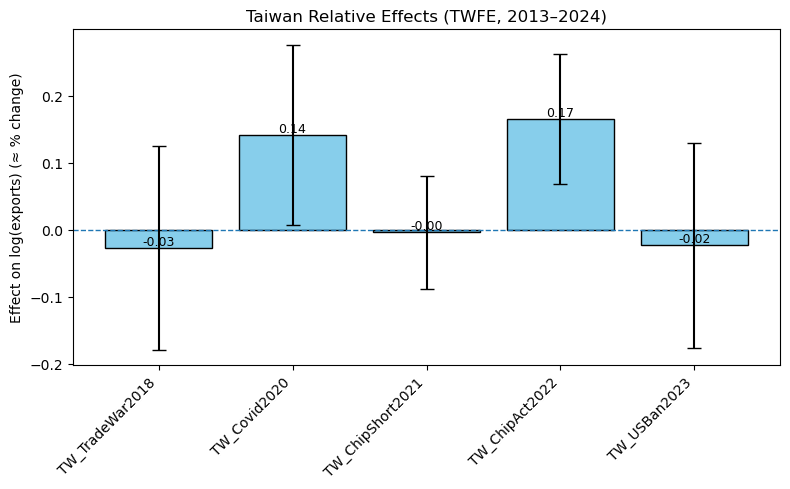

‚úÖ Saved figure with labels -> /home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/outputs/regression/tw_relative_effects_bar_labeled.png


<Figure size 640x480 with 0 Axes>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Ë∑ØÂæëË®≠ÂÆöÔºöÊ≤øÁî® Section 1 ÁöÑ PROC_DIR ===
OUT_DIR = Path(PROC_DIR).parent / "outputs" / "regression"
coef_path = OUT_DIR / "regression_results_TWFE.csv"

# ËÆÄ‰øÇÊï∏Ë°®
coef_raw = pd.read_csv(coef_path)

# Ê¨Ñ‰ΩçÂ∞çÊáâ
col_map = {
    "Coef.": "coef", "Coefficient": "coef", "coef": "coef",
    "Std.Err.": "stderr", "Std. Err.": "stderr", "std err": "stderr",
    "[0.025": "low", "2.5%": "low", "0.025": "low",
    "0.975]": "high", "97.5%": "high", "0.975": "high",
    "variable": "variable"
}
coef = coef_raw.rename(columns={k: v for k, v in col_map.items() if k in coef_raw.columns})

# Âè™Âèñ TW_* ‰∫§‰∫íÈ†Ö
coef = coef[coef["variable"].str.startswith("TW_")].copy()

# Â¶ÇÊûúÊ≤íÊúâ CI Ê¨Ñ‰ΩçÔºåÁî® stderr Ëøë‰ºº
if not {"low","high"}.issubset(coef.columns):
    coef["low"]  = coef["coef"] - 1.96 * coef["stderr"]
    coef["high"] = coef["coef"] + 1.96 * coef["stderr"]

# Âõ∫ÂÆöÈ†ÜÂ∫è
order = ["TW_TradeWar2018","TW_Covid2020","TW_ChipShort2021","TW_ChipAct2022","TW_USBan2023"]
coef["order"] = coef["variable"].map({v:i for i,v in enumerate(order)})
coef = coef.sort_values("order")

# Ë™§Â∑ÆÊ£í
yerr = [coef["coef"] - coef["low"], coef["high"] - coef["coef"]]

# Áπ™Âúñ
plt.figure(figsize=(8,5))
plt.axhline(0, linestyle="--", linewidth=1)

bars = plt.bar(
    coef["variable"],
    coef["coef"],
    yerr=yerr,
    capsize=5,
    color="skyblue",
    edgecolor="black"
)

# Ê®ôÊï∏Â≠óÔºàÈï∑Ê¢ù‰∏äÊñπÔºâ
for bar, val in zip(bars, coef["coef"]):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f"{val:.2f}", ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Effect on log(exports) (‚âà % change)")
plt.title("Taiwan Relative Effects (TWFE, 2013‚Äì2024)")
plt.tight_layout()
plt.show()

# Â≠òÊ™î
png_path = OUT_DIR / "tw_relative_effects_bar_labeled.png"
plt.savefig(png_path, dpi=150, bbox_inches="tight")
print("‚úÖ Saved figure with labels ->", png_path)


## 2.1 Baseline Regression (TWFE Ê®°Âûã)

- Êé°Áî® Two-Way Fixed Effects (TWFE) Ê®°ÂûãÔºö  
  - **ÂúãÂÆ∂Âõ∫ÂÆöÊïàÊûú (Country FE)**ÔºöÊéßÂà∂‰∏çÂêåÂúãÂÆ∂ÁöÑÈï∑ÊúüÂ∑ÆÁï∞Ôºà‰ª•‰∏≠ÂúãÁÇ∫Âü∫Ê∫ñÔºâ„ÄÇ  
  - **Âπ¥‰ªΩÂõ∫ÂÆöÊïàÊûú (Year FE)**ÔºöÂê∏Êî∂ÊâÄÊúâÂúãÂÆ∂ÂÖ±ÂêåÁöÑÂπ¥Â∫¶Ë°ùÊìäÔºà‰æãÂ¶ÇÂÖ®ÁêÉÈúÄÊ±ÇËÆäÂãïÔºâ„ÄÇ  
  - Âõ†Ê≠§Ôºå‰∫ã‰ª∂ dummyÔºàÂ¶Ç TradeWar2018, Covid2020 Á≠âÔºâÊúÉË¢´Âπ¥‰ªΩÂõ∫ÂÆöÊïàÊûúÂê∏Êî∂Ôºå  
    **Âè™Êúâ TW_* ‰∫§‰∫íÈ†ÖËÉΩÂèçÊò†Âè∞ÁÅ£Áõ∏Â∞çÊñºÂÖ∂‰ªñÂúãÂÆ∂ÁöÑÈ°çÂ§ñËÆäÂåñ**„ÄÇ

---

## 2.2 Taiwan Event Effects

### Ê¢ùÁãÄÂúñÔºàBar chartÔºâ
- È°ØÁ§∫Âè∞ÁÅ£Âú®ÂêÑÈáçÂ§ß‰∫ã‰ª∂‰∏ãÁöÑÁõ∏Â∞çÊïàÊûúÔºàÂê´ 95% ‰ø°Ë≥¥ÂçÄÈñìÔºâ„ÄÇ  

üëâ *ÂúñË°®Â∑≤ÁîüÊàêÔºàtw_relative_effects_bar_labeled.pngÔºâ*

### ‰∫ã‰ª∂ÊïàÊûúË°®Ê†º
| ‰∫ã‰ª∂ (TW_*)        | ‰øÇÊï∏ (log) | Á¥ÑÁï•Ëß£ËÆÄ (% Âá∫Âè£ËÆäÂåñ) | È°ØËëóÊÄß |
|-------------------|-----------|-----------------------|--------|
| TW_TradeWar2018   | -0.027    | -2.7%                 | n.s.   |
| **TW_Covid2020**  | **0.142** | **+14.2%**            | **\*\*** |
| TW_ChipShort2021  | -0.004    | -0.4%                 | n.s.   |
| **TW_ChipAct2022**| **0.165** | **+16.5%**            | **\*\*\*** |
| TW_USBan2023      | -0.023    | -2.3%                 | n.s.   |

### Ëß£ËÆÄÊëòË¶Å
- **Áñ´ÊÉÖ (2020)**ÔºöÂè∞ÁÅ£Âá∫Âè£Áõ∏Â∞çÂÖ∂‰ªñÂúãÂÆ∂È°ØËëóÊàêÈï∑ ‚âà **+14%**„ÄÇ  
- **CHIPS Act (2022)**ÔºöÂè∞ÁÅ£Âá∫Âè£Áõ∏Â∞çÂÖ∂‰ªñÂúãÂÆ∂È°ØËëóÊàêÈï∑ ‚âà **+16%**„ÄÇ  
- ÂÖ∂‰ªñ‰∫ã‰ª∂ÔºàË≤øÊòìÊà∞„ÄÅÊô∂ÁâáËçí„ÄÅGPU Á¶Å‰ª§ÔºâÂú®Áµ±Ë®à‰∏ä‰∏çÈ°ØËëóÔºå‰ª£Ë°®Âè∞ÁÅ£ËàáÂÖ∂‰ªñÂúãÂÆ∂Ê≤íÊúâÊòéÈ°ØÂ∑ÆÁï∞„ÄÇ  

---

## 2.3 Robustness Check

### (a) Period Dummy Analysis
- Â∞á 2013‚Äì2024 ÂàÜÁÇ∫ **ÂõõÂÄã‰∫íÊñ•ÂçÄÊÆµ**Ôºö  
  1. 2013‚Äì2017  
  2. 2018‚Äì2019  
  3. 2020‚Äì2021  
  4. 2022‚Äì2024  
- Ê™¢Êü•Âè∞ÁÅ£Âú®‰∏çÂêåÈöéÊÆµÁõ∏Â∞çÂÖ∂‰ªñÂúãÂÆ∂ÁöÑÂá∫Âè£Â∑ÆÁï∞„ÄÇ  
- ÁµêÊûúÈ°ØÁ§∫Ôºö2022‚Äì2024 Âè∞ÁÅ£Áõ∏Â∞çÊïàÊûúÊúÄÂº∑ÔºàÁ¥Ñ +19%ÔºâÔºåËàá CHIPS Act ÂàÜÊûê‰∏ÄËá¥„ÄÇ  

### (b) Event StudyÔºàËã•ÊúâÔºâ
- ÂèØ‰ª•ÂãïÊÖãÊ™¢Êü•‰∫ã‰ª∂ÂâçÂæåÁöÑËÆäÂåñÔºö  
  - **‰∫ã‰ª∂ÂâçË∂®Âã¢Ê™¢È©ó**ÔºöÁ¢∫Ë™çÂè∞ÁÅ£ËàáÂÖ∂‰ªñÂúãÂÆ∂Âú®‰∫ã‰ª∂ÂâçÊòØÂê¶Â∑≤Á∂ìÊúâÂ∑ÆÁï∞„ÄÇ  
  - **‰∫ã‰ª∂ÂæåÂãïÊÖãÊïàÊûú**ÔºöËßÄÂØüÂΩ±ÈüøÊòØÂê¶ÊåÅÁ∫å„ÄÅÊîæÂ§ßÊàñÊ∂àÂ§±„ÄÇ  

---

‚úÖ Â∞èÁµêÔºö  
TWFE Ê®°ÂûãÈ°ØÁ§∫ **Áñ´ÊÉÖ**Ëàá **CHIPS Act** Â∞çÂè∞ÁÅ£Âá∫Âè£ÁöÑÁõ∏Â∞çÊïàÊûúÈ°ØËëó„ÄÇ  
Robustness checkÔºà‰∫íÊñ•ÂçÄÊÆµ dummyÔºâÊîØÊåÅÁõ∏ÂêåÁµêË´ñ ‚Üí ÁµêÊûúÂÖ∑‰∏ÄËá¥ÊÄßËàáÂèØ‰ø°Â∫¶„ÄÇ


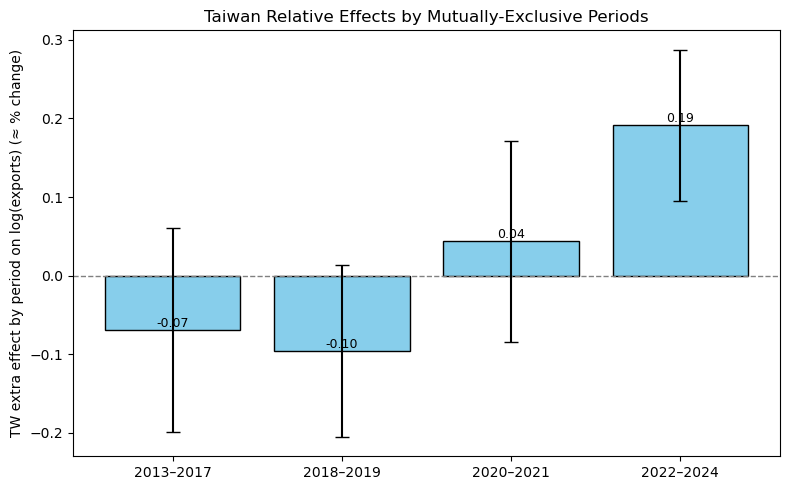

‚úÖ Saved figure -> /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression/tw_period_effects_bar_labeled.png


<Figure size 640x480 with 0 Axes>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# Ë∑ØÂæë
PROJECT_ROOT = Path(PROC_DIR).parents[2]
OUT_DIR = PROJECT_ROOT / "output" / "regression"
coef_csv = OUT_DIR / "period_model_results.csv"

# ËÆÄÁµêÊûúË°®‰∏¶ÂÅöÊ¨Ñ‰ΩçÂ∞çÊáâ
coef_tbl = pd.read_csv(coef_csv)
coef_tbl = coef_tbl.rename(columns={
    "Unnamed: 0": "term", "index": "term",
    "Coef.": "coef", "Coefficient": "coef", "coef": "coef",
    "Std.Err.": "stderr", "Std. Err.": "stderr", "std err": "stderr",
    "[0.025": "low", "2.5%": "low", "0.025": "low",
    "0.975]": "high", "97.5%": "high", "0.975": "high"
})

# ÊîØÊè¥ÂÖ©Á®ÆÂëΩÂêçÔºàÊ≥®ÊÑèÔºö‰Ω†ÁöÑË≥áÊñôÊ≤íÊúâ T.Ôºâ
pat1 = re.compile(r"TW:C\(Period\)\[(.+?)\]")
pat2 = re.compile(r"C\(Period\)\[(.+?)\]:TW")

rows = []
for _, r in coef_tbl.iterrows():
    term = str(r["term"])
    m1 = pat1.search(term)
    m2 = pat2.search(term)
    period = None
    if m1:
        period = m1.group(1)
    elif m2:
        period = m2.group(1)
    if period is not None:
        rows.append({
            "Period": period,
            "coef": r["coef"],
            "stderr": r.get("stderr", np.nan),
            "low": r.get("low", np.nan),
            "high": r.get("high", np.nan)
        })

tw_rows = pd.DataFrame(rows)
if tw_rows.empty:
    raise RuntimeError("‰ªçÊäì‰∏çÂà∞ TW√óPeriod ‰∫§‰∫íÈ†ÖÔºåË´ãÂÜçÊää coef_tbl['term'] ÂÖ®ÈÉ®ÂàóÂá∫‰æÜ„ÄÇ")

# CI ‰∏çÂú®Ë°®Â∞±Áî® 1.96*stderr Ëøë‰ºº
if not {"low","high"}.issubset(tw_rows.columns) or tw_rows["low"].isna().all():
    if "stderr" in tw_rows.columns and not tw_rows["stderr"].isna().all():
        tw_rows["low"]  = tw_rows["coef"] - 1.96 * tw_rows["stderr"]
        tw_rows["high"] = tw_rows["coef"] + 1.96 * tw_rows["stderr"]
    else:
        tw_rows["low"]  = tw_rows["coef"]
        tw_rows["high"] = tw_rows["coef"]

# Ë£ú‰∏äÂü∫Ê∫ñÊÆµÔºà2013‚Äì2017 = 0ÔºâÈÅøÂÖçÂúñÁº∫Ê¨Ñ
if "2013‚Äì2017" not in tw_rows["Period"].tolist():
    tw_rows = pd.concat([
        pd.DataFrame([{"Period": "2013‚Äì2017", "coef": 0.0, "low": 0.0, "high": 0.0}]),
        tw_rows
    ], ignore_index=True)

# ÊéíÂ∫èËàáÂéªÈáçÔºàÊúâ‰∫õÁâàÊú¨ÂÖ©Á®ÆÊ®£ÂºèÈÉΩÊúÉÂá∫ÁèæÔºåÈÄôË£°Âπ≥Âùá‰∏Ä‰∏ã‰ª•Èò≤ÈáçË§áÔºâ
order = ["2013‚Äì2017", "2018‚Äì2019", "2020‚Äì2021", "2022‚Äì2024"]
tw_rows = (tw_rows.groupby("Period", as_index=False)
           .agg(coef=("coef","mean"), low=("low","mean"), high=("high","mean")))
tw_rows["order"] = tw_rows["Period"].map({v:i for i,v in enumerate(order)})
tw_rows = tw_rows.sort_values("order")

# Áï´Âúñ
plt.figure(figsize=(8,5))
plt.axhline(0, color="gray", linestyle="--", linewidth=1)

yerr = [tw_rows["coef"] - tw_rows["low"], tw_rows["high"] - tw_rows["coef"]]
bars = plt.bar(tw_rows["Period"], tw_rows["coef"], yerr=yerr, capsize=5,
               color="skyblue", edgecolor="black")

# Ê®ôÊï∏Â≠óÔºàÈ°ØÁ§∫‰øÇÊï∏ ‚âà % ËÆäÂåñÔºâ
for bar, val in zip(bars, tw_rows["coef"]):
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, f"{val:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.ylabel("TW extra effect by period on log(exports) (‚âà % change)")
plt.title("Taiwan Relative Effects by Mutually-Exclusive Periods")
plt.tight_layout()
plt.show()

png_path = OUT_DIR / "tw_period_effects_bar_labeled.png"
plt.savefig(png_path, dpi=150, bbox_inches="tight")
print("‚úÖ Saved figure ->", png_path)


Using input: /home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/processed/ic_exports_comparison.csv
Saving to   : /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression

=== Event Study for Covid2020 (baseline k = -1) ===
                            OLS Regression Results                            
Dep. Variable:            log_exports   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     285.4
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           9.90e-26
Time:                        16:54:19   Log-Likelihood:                 34.714
No. Observations:                  48   AIC:                            -27.43
Df Residuals:                      27   BIC:                             11.87
Df Model:                          20                           

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 15
  warnings.warn('covariance of constraints does not have full '


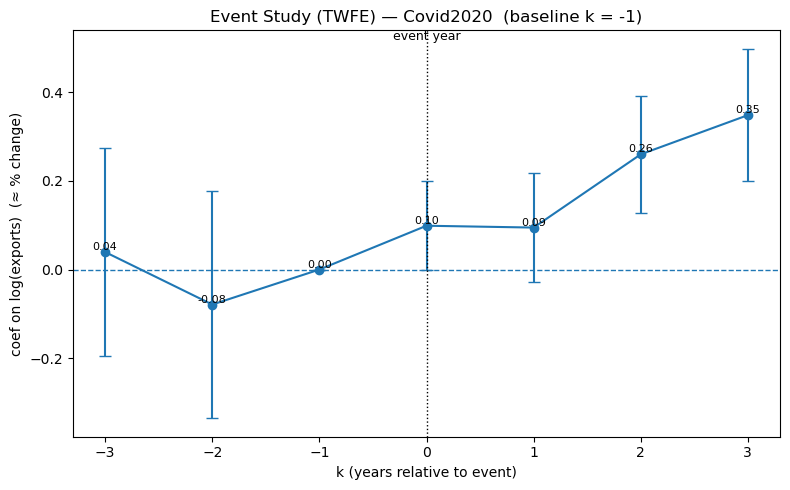

‚úÖ Saved figure -> /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression/event_study_Covid2020.png

=== Event Study for ChipAct2022 (baseline k = -1) ===
                            OLS Regression Results                            
Dep. Variable:            log_exports   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     224.6
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           4.31e-25
Time:                        16:54:20   Log-Likelihood:                 34.699
No. Observations:                  48   AIC:                            -29.40
Df Residuals:                      28   BIC:                             8.027
Df Model:                          19                                         
Covariance Type:                  HAC                                         
                          

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 15
  warnings.warn('covariance of constraints does not have full '


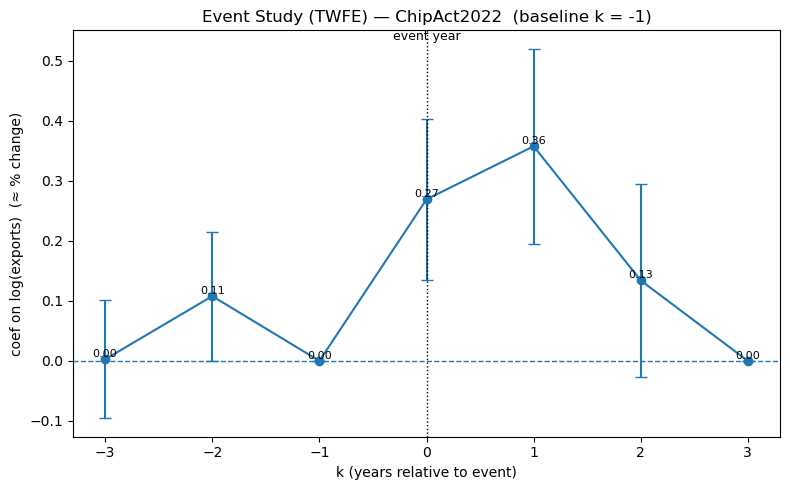

‚úÖ Saved figure -> /home/jovyan/work/data-visualization-labs/self-extended-practice/output/regression/event_study_ChipAct2022.png


k                term      coef       low      high  pct_approx(%)  \
0 -3  TW_ES_Covid2020_m3  0.039499 -0.194387  0.273384       3.949868   
1 -2  TW_ES_Covid2020_m2 -0.079053 -0.335773  0.177666      -7.905326   
2 -1        baseline(-1)  0.000000  0.000000  0.000000       0.000000   
3  0  TW_ES_Covid2020_p0  0.098906 -0.001921  0.199733       9.890561   
4  1  TW_ES_Covid2020_p1  0.094753 -0.028127  0.217632       9.475254   

   pct_exp(%)  
0    4.028913  
1   -7.600929  
2    0.000000  
3   10.396209  
4    9.938677

In [5]:
# === Event Study (TWFE) ‚Äî ÂÆåÊï¥ÂñÆ‰∏Ä cell ÂèØÂü∑Ë°å ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.formula.api as smf

# -------------------------------
# 1) Ë∑ØÂæëË®≠ÂÆö
# -------------------------------
try:
    PROC_DIR
except NameError:
    # ‰æù‰Ω†ÁöÑÂ∞àÊ°àË™øÊï¥Âà∞ data/processed
    PROC_DIR = Path("/home/jovyan/work/data-visualization-labs/self-extended-practice/semiconductor-tariff-impact-taiwan/data/processed")

PROJECT_ROOT = PROC_DIR.parents[2]         # .../semiconductor-tariff-impact-taiwan
OUT_DIR      = PROJECT_ROOT / "output" / "regression"
OUT_DIR.mkdir(parents=True, exist_ok=True)

IN_CSV = PROC_DIR / "ic_exports_comparison.csv"
print("Using input:", IN_CSV)
print("Saving to   :", OUT_DIR)

# -------------------------------
# 2) ËÆÄË≥áÊñô & Âü∫Êú¨ËôïÁêÜ
# -------------------------------
df = pd.read_csv(IN_CSV)
df = df[df["Country"].isin(["China", "Rep. of Korea", "USA", "Taiwan"])].copy()
df["Year"] = df["Year"].astype(int)
df["ExportValue(USD)"] = pd.to_numeric(df["ExportValue(USD)"], errors="coerce")
df = df.dropna(subset=["ExportValue(USD)"])
df["log_exports"] = np.log(df["ExportValue(USD)"])

# -------------------------------
# 3) ‰∫ã‰ª∂Á†îÁ©∂ÂáΩÂºèÔºàÂ∑≤‰øÆÊ≠£ËÆäÊï∏ÂëΩÂêçÔºåÈÅøÂÖç + / -Ôºâ
# -------------------------------
def run_event_study(df_reg: pd.DataFrame,
                    event_year: int,
                    event_label: str,
                    leads: int = 3,    # ‰∫ã‰ª∂ÂâçÊúÄÂ§öÂπæÂπ¥
                    lags: int  = 3,    # ‰∫ã‰ª∂ÂæåÊúÄÂ§öÂπæÂπ¥
                    treated_country: str = "Taiwan",
                    cov_type: str = "HAC",
                    maxlags: int = 1) -> pd.DataFrame:
    """
    TWFEÔºölog_exports ~ C(Country) + C(Year) + Œ£_k 1[Year - event_year == k] √ó 1[Taiwan]ÔºåÁúÅÁï• k = -1„ÄÇ
    Áî¢Âá∫Ôºö‰øÇÊï∏Ë°® (CSV) ËàáÂúñ (PNG)„ÄÇ
    """
    data = df_reg.copy()
    data["rel"] = data["Year"] - int(event_year)                  # Áõ∏Â∞ç‰∫ã‰ª∂Âπ¥ÁöÑÂπ¥Ë∑ù k
    data["is_TW"] = (data["Country"] == treated_country).astype(int)

    # Ê∫ñÂÇô k Á∂≤Ê†ºÔºõÁ¢∫‰øùÂåÖÂê´ -leads..+lags Ëàá -1ÔºàÂü∫Ê∫ñÊúüÔºâ
    k_grid = list(range(-leads, lags + 1))
    if -1 not in k_grid:
        k_grid.append(-1)
    k_grid = sorted(k_grid)

    # Âª∫Á´ã TW √ó D_k ‰∫§‰∫íÈ†ÖÔºõÊ¨ÑÂêçÁî® mX/pX ÈÅøÂÖç patsy Ëß£ÊûêÈåØË™§
    cols = []
    for k in k_grid:
        if k == -1:
            continue  # Âü∫Ê∫ñÊúüÁúÅÁï•
        suffix = f"m{abs(k)}" if k < 0 else f"p{k}"   # k=-3 -> m3, k=+2 -> p2
        col = f"TW_ES_{event_label}_{suffix}"
        data[col] = ((data["rel"] == k) & (data["is_TW"] == 1)).astype(int)
        cols.append(col)

    # TWFEÔºöCountry FE + Year FE + Âè∞ÁÅ£‰∫§‰∫íÈ†Ö
    if cols:
        rhs = " + ".join(cols)
        formula = f"log_exports ~ C(Country) + C(Year) + {rhs}"
    else:
        formula = "log_exports ~ C(Country) + C(Year)"
    mod = smf.ols(formula=formula, data=data).fit(cov_type=cov_type, cov_kwds={"maxlags": maxlags})

    print(f"\n=== Event Study for {event_label} (baseline k = -1) ===")
    print(mod.summary())

    # Êì∑Âèñ TW√óD_k ‰øÇÊï∏Ëàá 95% CIÔºõÂü∫Ê∫ñ k=-1 Ë£ú 0
    params = mod.params
    conf   = mod.conf_int()
    rows = []
    for k in k_grid:
        if k == -1:
            rows.append({"k": k, "term": f"baseline({k})", "coef": 0.0, "low": 0.0, "high": 0.0})
            continue
        suffix = f"m{abs(k)}" if k < 0 else f"p{k}"
        term = f"TW_ES_{event_label}_{suffix}"
        if term in params.index:
            rows.append({
                "k": k, "term": term,
                "coef": params[term],
                "low":  conf.loc[term, 0],
                "high": conf.loc[term, 1],
            })
        else:
            rows.append({"k": k, "term": term, "coef": np.nan, "low": np.nan, "high": np.nan})

    res = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
    # ËΩâÊàêÁôæÂàÜÊØîËß£ËÆÄÔºàÂÖ©Á®ÆÂè£ÂæëÔºâ
    res["pct_approx(%)"] = res["coef"] * 100
    res["pct_exp(%)"]    = (np.exp(res["coef"]) - 1.0) * 100

    # Â≠òË°®
    csv_path = OUT_DIR / f"event_study_{event_label}_coeffs.csv"
    res.to_csv(csv_path, index=False)
    print("‚úÖ Saved table ->", csv_path)

    # Ë¶ñË¶∫Âåñ
    plot_df = res.dropna(subset=["coef"]).copy()
    plt.figure(figsize=(8,5))
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.errorbar(
        plot_df["k"], plot_df["coef"],
        yerr=[plot_df["coef"] - plot_df["low"], plot_df["high"] - plot_df["coef"]],
        fmt="o-", capsize=4
    )
    # ‰∫ã‰ª∂Âπ¥Ê®ôÁ§∫
    plt.axvline(0, color="black", linestyle=":", linewidth=1)
    ymax = plt.ylim()[1]
    plt.text(0, ymax, "event year", ha="center", va="top", fontsize=9)

    # Êï∏Â≠óÊ®ôË®ªÔºàlog ‰øÇÊï∏Ôºâ
    for x, v in zip(plot_df["k"], plot_df["coef"]):
        plt.text(x, v, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

    plt.title(f"Event Study (TWFE) ‚Äî {event_label}  (baseline k = -1)")
    plt.xlabel("k (years relative to event)")
    plt.ylabel("coef on log(exports)  (‚âà % change)")
    plt.tight_layout()
    fig_path = OUT_DIR / f"event_study_{event_label}.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    plt.show()
    print("‚úÖ Saved figure ->", fig_path)

    return res

# -------------------------------
# 4) Âü∑Ë°åÂÖ©ÂÄã‰∫ã‰ª∂ÔºàÂèØËá™Ë°åÂ¢û‰øÆÔºâ
# -------------------------------
EVENTS = [
    {"year": 2020, "label": "Covid2020",   "leads": 3, "lags": 3},
    {"year": 2022, "label": "ChipAct2022", "leads": 3, "lags": 3},
]

all_results = {}
for ev in EVENTS:
    res = run_event_study(
        df, event_year=ev["year"], event_label=ev["label"],
        leads=ev["leads"], lags=ev["lags"], treated_country="Taiwan",
        cov_type="HAC", maxlags=1
    )
    all_results[ev["label"]] = res

# Ê™¢Ë¶ñ‰∏ÄÂÄãÁµêÊûúË°®È†≠
list(all_results.items())[0][1].head()
